<a href="https://colab.research.google.com/github/jackn11/CellSegmentationQuiz/blob/main/Segmenter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imports/downloads nnU-Net requirements

In [1]:
!pip install accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 8.5 MB/s eta 0:00:00


In [ ]:
# Installing nnUnet

!pip install nnunetv2 # More for use as baseline this way.

!git clone https://github.com/MIC-DKFZ/nnUNet.git
%cd nnUNet
!pip install -e .

In [ ]:
# Make sure to restart the runtime session before continuing, must not run following code in same runtime that was used for the pip installs

In [1]:
dir2 = dir # Store the dir function in a variable since dir name is overwritten later

In [2]:
import nnunetv2

Sets up the folder structure for nnU-Net


In [3]:
import os
import shutil
import sys
import json

In [4]:
IS_IN_COLAB = 'google.colab' in sys.modules # determines if running in colab or not

In [5]:
import os
os.getcwd()

'/content'

**Very important for code functionality that the dir variable is set to an existing folder that can be used. This code does it automatically**

In [6]:
# Sets the environment variables required for nnUNet to access the data storage folders
if IS_IN_COLAB:
  # Set cwd to in google drive so that stores saves
  dir = str(os.getcwd())+'/drive/MyDrive/Internal-ML-Quiz-WangLab/CWD'
else:
  dir = str(os.getcwd())

# Check if the directory exists
if not os.path.exists(dir):
    # Create the directory
    os.makedirs(dir)


main_dir = dir+"/nnUNet_folders"
data_already_in_place = os.path.exists(main_dir) # Used to determine if this program was run previously, thus having formatted the data as needed
if not data_already_in_place:
    # Create the main directory
    os.mkdir(main_dir)

    # Create the subdirectories
    sub_dirs = ["nnUNet_raw", "nnUNet_preprocessed", "nnUNet_results"]
    for sub_dir in sub_dirs:
        path = os.path.join(dir, main_dir, sub_dir)
        os.mkdir(path)

nnUNet_raw=dir+"/nnUNet_folders/nnUNet_raw"
nnUNet_preprocessed=dir+"/nnUNet_folders/nnUNet_preprocessed"
nnUNet_results=dir+"/nnUNet_folders/nnUNet_results"

os.environ['nnUNet_raw'] = nnUNet_raw
os.environ['nnUNet_preprocessed'] = nnUNet_preprocessed
os.environ['nnUNet_results'] = nnUNet_results

Import the data from google drive to local runtime (for colab only, not necessary if using github)

In [7]:
FORCE_NEW_DATA = False # Forces the data from the data folder to be rewritted to the raw folder in the correct dataset (does not overwrite results or models)

In [8]:
# TAKES ABOUT 1 MINUTE (in colab)

if (IS_IN_COLAB and ((not data_already_in_place) or FORCE_NEW_DATA)):
    # Get data from google drive since can't access github data
    folder_id = '1U1ElVBO9Rnm7P0BPe37B6VT2mmVVj5jl' # Just a part of the share folder url
    folder_path = '/content/drive/MyDrive/Internal-ML-Quiz-WangLab/data'
    cwd = os.getcwd()
    destination_path = cwd+'/data'

    # Prints the files to ensure copy was successful
    files = os.listdir(folder_path)
    print(files)

    # Copies the data from the google drive to the local runtime, takes about 1 minute
    shutil.copytree(folder_path, destination_path)

Data preprocessing

In [9]:
# This section will take the pictures, reformat their types and names to fit in
# with the nnU-Net requirements in their documentation.

from PIL import Image
import os

if (not data_already_in_place) or FORCE_NEW_DATA:

    # Get the current working directory.
    cwd = os.getcwd()
    # Create a path to the new folder.
    output_path = os.path.join(dir, "nnUNet_folders", "nnUNet_raw", "Dataset001_Base", "imagesTr")
    # Create a path to the data folder.
    imagesTr_path = os.path.join(cwd, "data", "imagesTr")


    # Create the new folder if it does not exist.
    os.makedirs(output_path, exist_ok=True)
    # Delete the old folder if it exists, even if it's not empty.
    shutil.rmtree(output_path, ignore_errors=False, onerror=None)
    # Create the new folder if it does not exist.
    os.makedirs(output_path, exist_ok=True)


    print('Beginning copying imagesTr')
    # Iterate over all files in the imagesTr folder.
    for filename in os.listdir(imagesTr_path):
        # Check if the file is a tiff or jpg image.
        if filename.endswith(".tiff") or filename.endswith(".jpg"):
            # Get the full path to the image file.
            image_path = os.path.join(imagesTr_path, filename)

            # Open the image file.
            with Image.open(image_path) as img:

                # Convert the image to RGB.
                rgb_img = img.convert("RGB")

                # Get the file extension.
                extension = os.path.splitext(filename)[1]

                # Save the image as a png file with the same name in the output folder.
                new_filename = filename.replace(extension, "_0000.png")
                new_image_path = os.path.join(output_path, new_filename)
                rgb_img.save(new_image_path)
    print('Done copying imagesTr')
    print()



    # Now that done copying training inputs, copy training labels

    # Assuming cwd is defined (current working directory)
    cwd = os.getcwd()  # Make sure this points to your project's root directory

    # Define the path to the new folder for labels
    output_path = os.path.join(dir, "nnUNet_folders", "nnUNet_raw", "Dataset001_Base", "labelsTr")
    # Define the path to the source folder containing the original label files
    imagesTr_path = os.path.join(cwd, "data", "labelsTr")

    # Make sure the output directory exists
    os.makedirs(output_path, exist_ok=True)

    # First, ensure the target directory is empty to avoid file conflicts
    shutil.rmtree(output_path, ignore_errors=True)
    os.makedirs(output_path, exist_ok=True)

    print('Beginning copying labelsTr')

    # List all files in the source directory
    for file_name in os.listdir(imagesTr_path):
        # Check if the file name ends with '_label'
        # Construct the full path to the source file
        src_file_path = os.path.join(imagesTr_path, file_name)
        # Remove '_label' from the file name for the destination file
        dest_file_name = file_name.replace('_label', '')
        # Construct the full path to the destination file
        dest_file_path = os.path.join(output_path, dest_file_name)
        # Copy the file from source to destination
        shutil.copy(src_file_path, dest_file_path)

    print('Finished copying and renaming files to labelsTr')





    # Get the current working directory.
    cwd = os.getcwd()
    # Create a path to the new folder.
    output_path = os.path.join(dir, "nnUNet_folders", "nnUNet_raw", "Dataset001_Base", "imagesTs-Internal")
    # Create a path to the data folder.
    imagesTr_path = os.path.join(cwd, "data", "imagesTs-Internal")


    # Create the new folder if it does not exist.
    os.makedirs(output_path, exist_ok=True)
    # Delete the old folder if it exists, even if it's not empty.
    shutil.rmtree(output_path, ignore_errors=False, onerror=None)
    # Create the new folder if it does not exist.
    os.makedirs(output_path, exist_ok=True)


    print('Beginning copying imagesTs-Internal')
    # Iterate over all files in the imagesTr folder.
    for filename in os.listdir(imagesTr_path):
        # Check if the file is a tiff or jpg image.
        if filename.endswith(".tiff") or filename.endswith(".jpg"):
            # Get the full path to the image file.
            image_path = os.path.join(imagesTr_path, filename)

            # Open the image file.
            with Image.open(image_path) as img:

                # Convert the image to RGB.
                rgb_img = img.convert("RGB")

                # Get the file extension.
                extension = os.path.splitext(filename)[1]

                # Save the image as a png file with the same name in the output folder.
                new_filename = filename.replace(extension, "_0000.png")
                new_image_path = os.path.join(output_path, new_filename)
                rgb_img.save(new_image_path)
    print('Done copying imagesTs-Internal')
    print()





    # Get the current working directory.
    cwd = os.getcwd()
    # Create a path to the new folder.
    output_path = os.path.join(dir, "nnUNet_folders", "nnUNet_raw", "Dataset001_Base", "imagesTs-External")
    # Create a path to the data folder.
    imagesTr_path = os.path.join(cwd, "data", "imagesTs-External")


    # Create the new folder if it does not exist.
    os.makedirs(output_path, exist_ok=True)
    # Delete the old folder if it exists, even if it's not empty.
    shutil.rmtree(output_path, ignore_errors=False, onerror=None)
    # Create the new folder if it does not exist.
    os.makedirs(output_path, exist_ok=True)


    print('Beginning copying imagesTs-External')
    # Iterate over all files in the imagesTr folder.
    for filename in os.listdir(imagesTr_path):
        # Check if the file is a tiff or jpg image.
        if filename.endswith(".tiff") or filename.endswith(".jpg"):
            # Get the full path to the image file.
            image_path = os.path.join(imagesTr_path, filename)

            # Open the image file.
            with Image.open(image_path) as img:

                # Convert the image to RGB.
                rgb_img = img.convert("RGB")

                # Get the file extension.
                extension = os.path.splitext(filename)[1]

                # Save the image as a png file with the same name in the output folder.
                new_filename = filename.replace(extension, "_0000.png")
                new_image_path = os.path.join(output_path, new_filename)
                rgb_img.save(new_image_path)
    print('Done copying imagesTs-External')
    print()

In [10]:
# Defines the function for displaying a cell image or label

from PIL import Image
from IPython.display import display
import random
import string

def display_image(label_path, LABEL = False):
    # Open the image file.
    spec_img_path = os.path.join(dir, "nnUNet_folders", "nnUNet_raw", "Dataset001_Base", "labelsTr", "img_006.png")
    spec_img_path = label_path
    image = Image.open(spec_img_path)

    # Get the pixel values.
    pixels = image.load()

    # Create a new image with the same dimensions.
    new_image = Image.new("RGB", image.size)

    if LABEL == True: # Label, not cell image
        # Iterate over all pixels and set their color.
        for x in range(image.width):
            for y in range(image.height):
                pixel_value = pixels[x, y]
                if pixel_value == 1:
                    new_image.putpixel((x, y), (255, 0, 0))  # Red
                elif pixel_value == 2:
                    new_image.putpixel((x, y), (0, 0, 255))  # Blue
    else: # Cell image, not label
        new_image = image.copy()

    # Display the new image.
    new_image.show()

    # Display the image in a specific location.
    random_string = ''.join(random.choices(string.digits, k=3))
    display(new_image, display_id=("my_image"+random_string))

In [11]:
# JSON descriptor created here

data = {
  "channel_names": {
    "0": "Red",
    "1": "Green",
    "2": "Blue"
  },
  "labels": {
    "background": 0,
    "cytoplasms": 1,
    "nucleus": 2
  },
  "numTraining": 231,
  "file_ending": ".png",
}

json_string = json.dumps(data, indent=4)

json_path = os.path.join(dir, "nnUNet_folders", "nnUNet_raw", "Dataset001_Base", "dataset.json")

with open(json_path, 'w') as outfile:
    json.dump(data, outfile, indent=4)

In [ ]:
!nnUNetv2_plan_and_preprocess -d 1 --verify_dataset_integrity

In [12]:
# Import statements for machine learning
import torch

In [13]:
inference_dir = dir + "/inferences"
nnUNet_inference_dir = inference_dir + "/nnUNet_inferences"

In [14]:
!nvidia-smi

Thu Feb 22 11:23:58 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0              43W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [ ]:
# trains multiple folds simultaneously
# takes approximately 250 seconds per epoch on A100 gpu
import subprocess

# Define your commands
commands = [
    'CUDA_VISIBLE_DEVICES=0 nnUNetv2_train 1 2d 0 --npz --c -device cuda',
    'CUDA_VISIBLE_DEVICES=0 nnUNetv2_train 1 2d 1 --npz --c -device cuda',
    'CUDA_VISIBLE_DEVICES=0 nnUNetv2_train 1 2d 2 --npz --c -device cuda',
    'CUDA_VISIBLE_DEVICES=0 nnUNetv2_train 1 2d 3 --npz --c -device cuda',
    'CUDA_VISIBLE_DEVICES=0 nnUNetv2_train 1 2d 4 --npz --c -device cuda',
]

# Start each command in a separate subprocess
processes = [subprocess.Popen(cmd, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE) for cmd in commands]

# Optionally, wait for the processes to complete and capture their outputs
for p in processes:
    stdout, stderr = p.communicate()
    print(stdout.decode(), stderr.decode())

In [ ]:
# Alternatively training can be done one at a time

# !CUDA_VISIBLE_DEVICES=0 nnUNetv2_train 1 2d 1 --npz --c -device cuda

In [ ]:
# This cell gathers the necessary info from each model to find best config and run inference
# Takes about 10 minutes to run (in colab)

# Assuming you want to train on folds 0 through 4
for fold in range(5):  # This will generate numbers 0, 1, 2, 3, 4
    print(f"Starting training for fold {fold}")
    !CUDA_VISIBLE_DEVICES=0 nnUNetv2_train Dataset001_Base 2d {fold} --val --npz
    print(f"Finished training for fold {fold}")

Starting training for fold 0
Using device: cuda:0

#######################################################################
Please cite the following paper when using nnU-Net:
Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
#######################################################################

2024-02-21 13:16:25.501606: Using splits from existing split file: /content/drive/MyDrive/Internal-ML-Quiz-WangLab/CWD/nnUNet_folders/nnUNet_preprocessed/Dataset001_Base/splits_final.json
2024-02-21 13:16:25.512726: The split file contains 5 splits.
2024-02-21 13:16:25.517048: Desired fold for training: 0
2024-02-21 13:16:25.522285: This split has 184 training and 47 validation cases.
2024-02-21 13:16:25.528312: predicting img_014
2024-02-21 13:16:25.553944: img_014, shape torch.Size([3, 1, 400, 400]), rank 0
2024-02-21 13:16:27.556622: pred

In [ ]:
# Find the best configuration after having done training
!nnUNetv2_find_best_configuration Dataset001_Base

Configuration 3d_fullres not found in plans nnUNetPlans.
Inferred plans file: /content/drive/MyDrive/Internal-ML-Quiz-WangLab/CWD/nnUNet_folders/nnUNet_preprocessed/Dataset001_Base/nnUNetPlans.json.
Configuration 3d_lowres not found in plans nnUNetPlans.
Inferred plans file: /content/drive/MyDrive/Internal-ML-Quiz-WangLab/CWD/nnUNet_folders/nnUNet_preprocessed/Dataset001_Base/nnUNetPlans.json.
Configuration 3d_cascade_fullres not found in plans nnUNetPlans.
Inferred plans file: /content/drive/MyDrive/Internal-ML-Quiz-WangLab/CWD/nnUNet_folders/nnUNet_preprocessed/Dataset001_Base/nnUNetPlans.json.

***All results:***
nnUNetTrainer__nnUNetPlans__2d: 0.8941988809498442

*Best*: nnUNetTrainer__nnUNetPlans__2d: 0.8941988809498442

***Determining postprocessing for best model/ensemble***
Removing all but the largest foreground region did not improve results!
Removing all but the largest component for 1 did not improve results! Dice before: 0.82947 after: 0.82321
Removing all but the largest 

In [ ]:
# Run inference with the previously trained model on the training data
RUN_NNUNET_INFERENCE_1 = True

if RUN_NNUNET_INFERENCE_1:
    nnUNet_inference_dir_1 = nnUNet_inference_dir + "/nnUNet_inference_1/imagesTr"
    !nnUNetv2_predict -d Dataset001_Base -i {dir}/nnUNet_folders/nnUNet_raw/Dataset001_Base/imagesTr -o {nnUNet_inference_dir_1} -f  0 1 2 3 4 -tr nnUNetTrainer -c 2d -p nnUNetPlans


#######################################################################
Please cite the following paper when using nnU-Net:
Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
#######################################################################

There are 231 cases in the source folder
I am process 0 out of 1 (max process ID is 0, we start counting with 0!)
There are 231 cases that I would like to predict

Predicting img_000:
perform_everything_on_device: True
100% 1/1 [00:00<00:00,  1.50it/s]
100% 1/1 [00:00<00:00, 29.08it/s]
100% 1/1 [00:00<00:00, 29.38it/s]
100% 1/1 [00:00<00:00, 29.35it/s]
100% 1/1 [00:00<00:00, 29.33it/s]
sending off prediction to background worker for resampling and export
done with img_000

Predicting img_001:
perform_everything_on_device: True
100% 1/1 [00:00<00:00, 26.19it/s]
100% 1/1 [00:00<00:00, 29.82it

Inference Label:


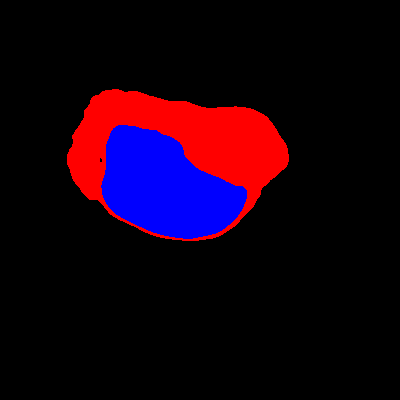


Ground Truth Label:


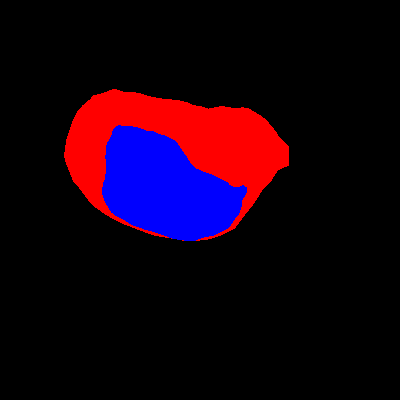


Train Image:


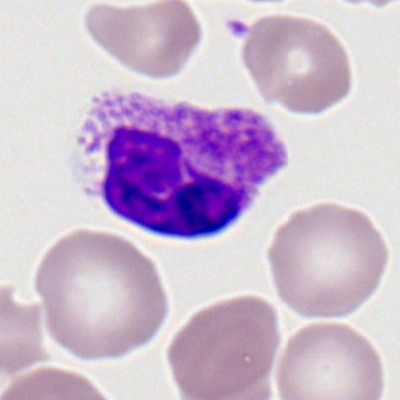

In [ ]:
# This block of code is used to show the comparison between inference labels, ground truth label, and actual image.

img_num = '009'
print("Inference Label:")
display_image(nnUNet_inference_dir_1 + '/img_'+img_num+'.png', LABEL = True) # Inference Label
print()
print("Ground Truth Label:")
display_image(dir+"/nnUNet_folders/nnUNet_raw/Dataset001_Base/labelsTr"+"/img_"+img_num+'.png', LABEL = True)
print()
print("Train Image:")
display_image(dir+"/nnUNet_folders/nnUNet_raw/Dataset001_Base/imagesTr"+"/img_"+img_num+"_0000.png", LABEL = False)

In [ ]:
# Run inference with the previously trained model on internal test
RUN_NNUNET_INFERENCE_2 = True

if RUN_NNUNET_INFERENCE_2:
    nnUNet_inference_dir_2 = nnUNet_inference_dir + "/nnUNet_inference_1/imagesTs-Internal"
    !nnUNetv2_predict -d Dataset001_Base -i {dir}/nnUNet_folders/nnUNet_raw/Dataset001_Base/imagesTs-Internal -o {nnUNet_inference_dir_2} -f  0 1 2 3 4 -tr nnUNetTrainer -c 2d -p nnUNetPlans


#######################################################################
Please cite the following paper when using nnU-Net:
Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
#######################################################################

There are 77 cases in the source folder
I am process 0 out of 1 (max process ID is 0, we start counting with 0!)
There are 77 cases that I would like to predict

Predicting Internal_img_000:
perform_everything_on_device: True
100% 1/1 [00:00<00:00,  1.51it/s]
100% 1/1 [00:00<00:00, 29.89it/s]
100% 1/1 [00:00<00:00, 29.06it/s]
100% 1/1 [00:00<00:00, 29.72it/s]
100% 1/1 [00:00<00:00, 29.16it/s]
sending off prediction to background worker for resampling and export
done with Internal_img_000

Predicting Internal_img_001:
perform_everything_on_device: True
100% 1/1 [00:00<00:00, 29.66it/s]
100% 

Inference Label:


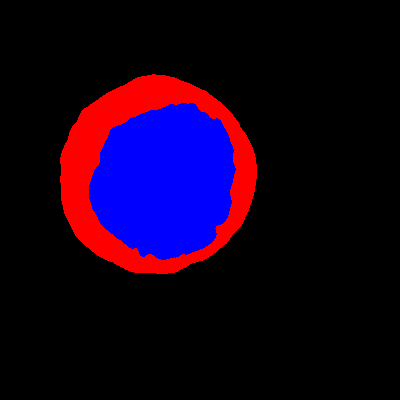


Internal Test Image:


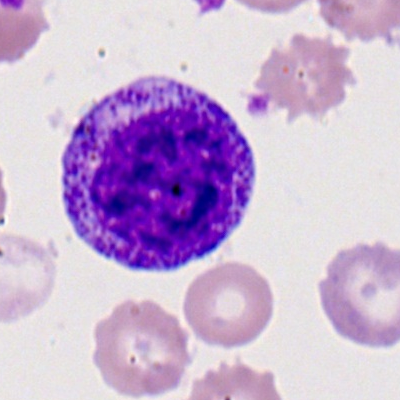

In [ ]:
# Internal Test
# This block of code is used to show the comparison between inference labels, and actual image.

img_num = '031'
print("Inference Label:")
display_image(nnUNet_inference_dir_2 + '/Internal_img_'+img_num+'.png', LABEL = True) # Inference Label
print()
print("Internal Test Image:")
display_image(dir+"/nnUNet_folders/nnUNet_raw/Dataset001_Base/imagesTs-Internal"+"/Internal_img_"+img_num+"_0000.png", LABEL = False)

In [ ]:
# Run inference with the previously trained model on external test
RUN_NNUNET_INFERENCE_3 = True

if RUN_NNUNET_INFERENCE_3:
    nnUNet_inference_dir_3 = nnUNet_inference_dir + "/nnUNet_inference_1/imagesTs-External"
    !nnUNetv2_predict -d Dataset001_Base -i {dir}/nnUNet_folders/nnUNet_raw/Dataset001_Base/imagesTs-External -o {nnUNet_inference_dir_3} -f  0 1 2 3 4 -tr nnUNetTrainer -c 2d -p nnUNetPlans


#######################################################################
Please cite the following paper when using nnU-Net:
Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
#######################################################################

There are 60 cases in the source folder
I am process 0 out of 1 (max process ID is 0, we start counting with 0!)
There are 60 cases that I would like to predict

Predicting External_img_000:
perform_everything_on_device: True
100% 1/1 [00:00<00:00,  1.49it/s]
100% 1/1 [00:00<00:00, 29.14it/s]
100% 1/1 [00:00<00:00, 28.40it/s]
100% 1/1 [00:00<00:00, 27.60it/s]
100% 1/1 [00:00<00:00, 29.23it/s]
sending off prediction to background worker for resampling and export
done with External_img_000

Predicting External_img_001:
perform_everything_on_device: True
100% 1/1 [00:00<00:00, 30.14it/s]
100% 

Inference Label:


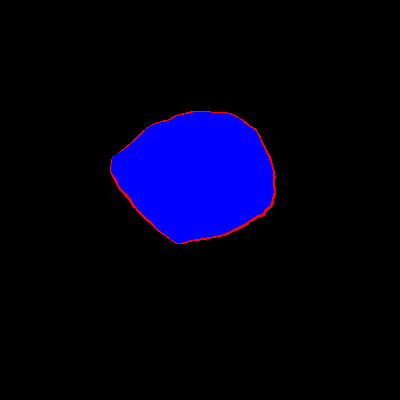


External Test Image:


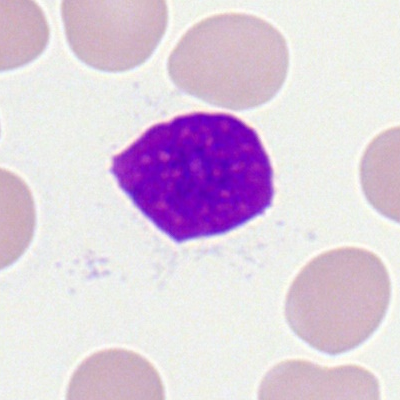

In [ ]:
# External Test
# This block of code is used to show the comparison between inference labels, and actual image.
import time

for i in range(0, 1):
    if i<10:
        img_num = '00'+str(i)
    else:
        img_num = '0'+str(i)
    print("Inference Label:")
    display_image(nnUNet_inference_dir_3 + '/External_img_'+img_num+'.png', LABEL = True) # Inference Label
    print()
    print("External Test Image:")
    display_image(dir+"/nnUNet_folders/nnUNet_raw/Dataset001_Base/imagesTs-External"+"/External_img_"+img_num+"_0000.png", LABEL = False)
    time.sleep(2)

In [ ]:
# Fit file names

for inf_dir in [nnUNet_inference_dir_2, nnUNet_inference_dir_3]:
    # Check if the directory exists
    if os.path.exists(inf_dir):
        # List all files in the directory
        files = os.listdir(inf_dir)

        # Rename each file by adding "_label" before the file extension
        for file in files:
            # Split the file name and its extension
            name, ext = os.path.splitext(file)
            # New file name with "_label" added before the extension
            new_name = f"{name}_label{ext}"
            # Full path for old and new file names
            old_file = os.path.join(inf_dir, file)
            new_file = os.path.join(inf_dir, new_name)
            # Rename the file
            os.rename(old_file, new_file)

        # List all files in the directory after renaming to verify the changes
        updated_files = os.listdir(inf_dir)
        updated_files
    else:
        updated_files = "Directory does not exist."

Now time for the transformer model

Now the nnU-Net model is done and the rest of the program focuses on the transformer model

In [ ]:
!pip install torch torchvision transformers

In [15]:
# Import statements
from torch.utils.data import Dataset, DataLoader
from PIL import Image, ImageOps
import os
import numpy as np

In [16]:
# Sets directory variables
dataset_001_dir = dir + '/nnUNet_folders/nnUNet_raw/Dataset001_Base'
img_dir= dataset_001_dir+'/imagesTr'
mask_dir=dataset_001_dir+'/labelsTr'

In [17]:
# Sets inference directory variables

# inference_dir = dir + "/inferences" # Just for show, inference_dir defined above
segformer_inference_dir = inference_dir + "/segformer_inferences"
segformer_inference_dir_1 = "/segformer_inference_1/imagesTr"

In [18]:
# This section is for implementing data augmentation

In [19]:
import albumentations as A
import cv2
from albumentations.pytorch import ToTensorV2
from albumentations import Compose, RandomRotate90, Flip, OneOf, ElasticTransform, GridDistortion, OpticalDistortion

In [20]:
def get_training_augmentation():
    train_transform = A.Compose(
        [
            A.RandomCrop(width=300, height=300, p=0.3),
            A.Resize(height=400, width=400),
            A.Rotate(limit=40, p=0.9, border_mode=cv2.BORDER_CONSTANT),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.RGBShift(r_shift_limit=20, g_shift_limit=20, b_shift_limit=20, p=0.4),
            A.OneOf([
                A.Blur(blur_limit=3, p=0.5),
                A.ColorJitter(p=0.5),
            ], p=0.4),
        ]
    )
    return train_transform

In [21]:
# Done data augmentation function implementation

In [22]:
# This block defintes the a segmentation dataset class that can be used to store and retrieve items from a dataset

from PIL import ImageFile
class CustomSegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, (self.images[idx]).replace('_0000', ''))  # Assuming mask and image have the same filename
        image = Image.open(image_path).convert("RGB")#nonparr
        mask = Image.open(mask_path)#nonpyarr

        # if self.transform is not None:
        #     image, mask = self.transform(image, mask)

        # If the transform is given then apply the data augmentations to the data when it is retrieved from the dataset
        if self.transform:
            # print('here1')
            #new
            image = np.array(image)
            mask = np.array(mask)
            #endnew
            augmented = self.transform(image=image, mask=mask)
            # print('hereend')
            image = Image.fromarray(augmented['image'])# didn't have image.fromarray before
            mask = Image.fromarray(augmented['mask'])# didn't have image.fromarray before

        return {"pixel_values": image, "labels": mask}

In [23]:
# Padding applied for simplicity to make training tensors the same size

def pad_to_size(img, size=(400, 400)):
    """
    Pads an image to the specified size with black (0 value) padding.

    Parameters:
    - img: PIL.Image object, the input image.
    - size: tuple, the target size as (width, height).

    Returns:
    - A PIL.Image object of the specified size.
    """
    # Ensure the image is in RGB mode
    if img.mode != 'RGB':
        img = img.convert('RGB')

    # Create a new image with the desired size and black background
    new_img = Image.new('RGB', size, (0, 0, 0))

    # Calculate padding
    left = (size[0] - img.width) // 2
    top = (size[1] - img.height) // 2

    # Paste the original image onto the center of the new image
    new_img.paste(img, (left, top))

    return new_img

def pad_to_size_mask(img, size=(400, 400)):
    """
    Pads an image (segmentation mask) to the specified size with black (0 value) padding,
    ensuring the image has only one channel (grayscale) suitable for segmentation tasks
    with label values in the range of 0, 1, 2.

    Parameters:
    - img: PIL.Image object, the input image.
    - size: tuple, the target size as (width, height).

    Returns:
    - A PIL.Image object of the specified size, in single-channel mode.
    """
    # Ensure the image is in single-channel mode ('L' for 8-bit pixels, black and white)
    if img.mode != 'L':
        # Convert to grayscale. This might require custom logic to map RGB to labels (0, 1, 2)
        img = img.convert('L')

    # Create a new image with the desired size and black background, in single-channel mode
    new_img = Image.new('L', size, 0)

    # Calculate padding
    left = (size[0] - img.width) // 2
    top = (size[1] - img.height) // 2

    # Paste the original image onto the center of the new image
    new_img.paste(img, (left, top))

    return new_img

def print_size_func(img):
    # print('new size: '+str(img.size))
    return img

In [24]:
from torchvision.transforms import Compose, ToTensor, Normalize
from torchvision.transforms.functional import to_pil_image
import torch

# This function contains the transforms that are applied to every training image
def get_transforms():
    return Compose([
        pad_to_size,
        print_size_func,
        ToTensor(),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

# This function is used to assemble the tensor that will be sent to the model during training
def custom_collate_fn(batch):
    images, masks = zip(*[(item['pixel_values'], item['labels']) for item in batch])
    # print('type: '+str(type(images[0])))
    images = torch.stack([get_transforms()(image) for image in images])
    masks = torch.stack([torch.tensor(np.array(pad_to_size_mask(mask), dtype=np.int64)) for mask in masks])
    return {"pixel_values": images, "labels": masks}


In [25]:
# This cell takes the training data, sets it up for dynamic augmentation during training, and then splits it into train and test sets

from torch.utils.data import random_split

# Initialize the dataset
all_dataset = CustomSegmentationDataset(image_dir=img_dir, mask_dir=mask_dir, transform=get_training_augmentation())
# eval_dataset = CustomSegmentationDataset(image_dir='/content/drive/MyDrive/Internal-ML-Quiz-WangLab/CWD/nnUNet_folders/nnUNet_raw/Dataset001_Base/imagesTs-Internal', mask_dir='/content/drive/MyDrive/Internal-ML-Quiz-WangLab/CWD/inferences/nnUNet_inferences/nnUNet_inference_1/imagesTs-Internal', transform=None)

# Assuming `all_dataset` is your entire dataset loaded into a PyTorch Dataset object
# Let's also assume the size of your dataset
total_size = len(all_dataset)
train_size = int(total_size * 0.80)  # 80% for training
val_size = total_size - train_size  # 20% for validation

# Split the dataset into training and validation sets
train_dataset, eval_dataset = random_split(all_dataset, [train_size, val_size])

<PIL.Image.Image image mode=RGB size=400x400 at 0x79E4EE92B730>


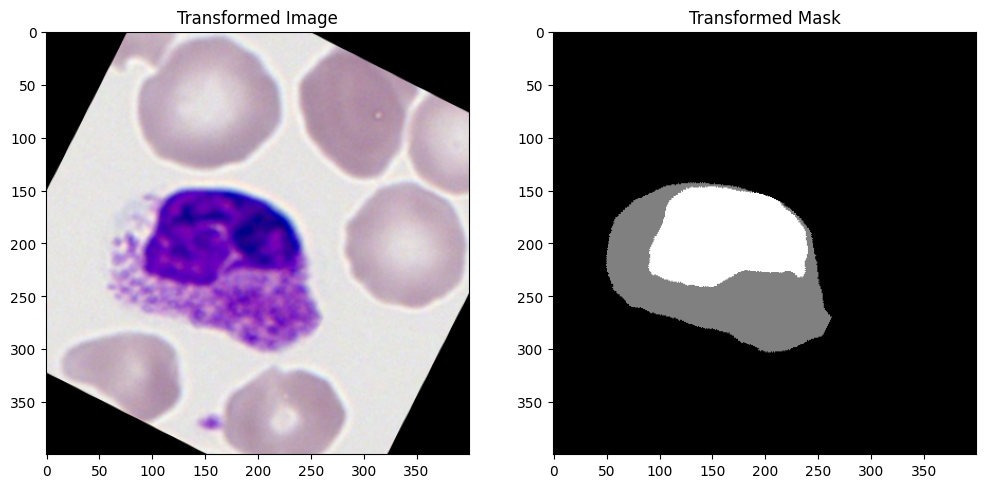

In [26]:
# This section accesses and displays a training image, thus dynamically augmenting it.
# This allows us to get a sense of the dataset and of the augmentations being performed.

import matplotlib.pyplot as plt

# Assuming you want to visualize the first item in the training dataset
data_item = train_dataset[0]

print(data_item['pixel_values'])

# If your `__getitem__` method returns a dictionary with 'pixel_values' and 'labels' as keys
transformed_image = np.array(data_item['pixel_values'])  # This should already be a transformed image
# transformed_image = transformed_image.permute(1, 2, 0)
# transformed_image = transformed_image.transpose(0, 1, 2)
transformed_mask = data_item['labels']         # This should already be a transformed mask

# Assuming the transformed images and masks are in a compatible format for direct plotting
# (e.g., NumPy arrays that matplotlib can handle)
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(transformed_image)
plt.title('Transformed Image')

plt.subplot(1, 2, 2)
plt.imshow(transformed_mask, cmap='gray')
plt.title('Transformed Mask')

plt.show()


In [27]:
# Functions to be used during training

In [28]:
# This cell defines a callback to plot the training curve.
# Currently, it is set to display when all of the training epochs are complete.

from transformers import TrainerCallback
import matplotlib.pyplot as plt

class PlottingCallback(TrainerCallback):
    """
    A custom callback to plot both training and validation loss curves without relying on 'step' in logs.

    This callback captures training loss and validation loss during the training
    and provides a method to plot these loss curves after training has completed.
    Manually tracks the invocation count for logging and evaluation as proxies for steps.
    """
    def __init__(self):
        super().__init__()
        self.training_losses = []  # Store training losses
        self.validation_losses = []  # Store validation losses
        self.log_invocations = 0  # Count log invocations as a proxy for training steps
        self.eval_invocations = 0  # Count eval invocations as a proxy for evaluation points

    def on_log(self, args, state, control, logs=None, **kwargs):
        """
        Called whenever the Trainer logs events.
        """
        if 'loss' in logs:
            self.training_losses.append(logs['loss'])
            self.log_invocations += 1  # Increment log invocation count

    def on_evaluate(self, args, state, control, metrics=None, **kwargs):
        """
        Called whenever the Trainer evaluates the model.
        """
        if 'eval_loss' in metrics:
            self.validation_losses.append(metrics['eval_loss'])
            self.eval_invocations += 1  # Increment eval invocation count

    def plot_loss_curves(self):
        """
        Plot the training and validation loss curves using invocation counts as proxies for steps.
        """
        plt.figure(figsize=(10, 5))

        # Generate X values for training loss plot based on the number of log invocations
        training_steps = list(range(1, self.log_invocations + 1))
        if training_steps and self.training_losses:
            plt.plot(training_steps, self.training_losses, label='Training Loss')

        # Generate X values for validation loss plot based on the number of eval invocations
        eval_points = list(range(1, self.eval_invocations + 1))
        if eval_points and self.validation_losses:
            plt.plot(eval_points, self.validation_losses, label='Validation Loss', linestyle='--')

        plt.xlabel('Number of Invocations')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss Curves')
        plt.legend()
        plt.show()


In [29]:
# This cell implements functions to calculate the dice coefficient between the predicted mask and ground truth.
# This is used during training, the dice per class is shown every few iterations to show how the model is improving.

from transformers import EvalPrediction
import torch

def dice_coefficient(preds, labels, smooth=1e-6):
    """
    Calculate the Dice coefficient between predictions and labels for multi-class segmentation, per class.

    Args:
        preds: Predicted segmentation maps as a NxCxHxW tensor, where N is the batch size, C is the number of classes,
               and HxW is the spatial dimension of the segmentation map.
        labels: Ground truth segmentation maps as a NxHxW tensor, where each pixel value is the class label.
        smooth: A small constant to avoid division by zero.

    Returns:
        A dictionary with class indices as keys and the corresponding Dice coefficient as values.
    """
    num_classes = preds.shape[1]
    preds = torch.softmax(preds, dim=1)  # Apply softmax to get probabilities if not already done
    labels_one_hot = torch.nn.functional.one_hot(labels, num_classes).permute(0, 3, 1, 2)  # Convert labels to one-hot encoding

    dice_scores = {}  # Dictionary to store dice scores for each class
    for i in range(num_classes):
        pred_flat = preds[:, i, :, :].contiguous().view(-1)
        labels_flat = labels_one_hot[:, i, :, :].contiguous().view(-1)

        intersection = (pred_flat * labels_flat).sum()
        dice_score = (2. * intersection + smooth) / (pred_flat.sum() + labels_flat.sum() + smooth)
        dice_scores[f'class_{i}'] = dice_score.item()  # Convert to Python scalar

    return dice_scores

def compute_metrics(p):
    """
    Compute the Dice coefficient for the eval dataset, per class.

    Args:
        p: An object with the following fields:
            predictions: the model's predictions as a NxCxHxW tensor
            label_ids: the ground truth labels as a NxHxW tensor

    Returns:
        A dictionary with metric names as keys and their computed values as values. Here, metric names are class indices.
    """

    preds = torch.tensor(p.predictions)  # Assuming predictions are in the right shape NxCxHxW
    labels = torch.tensor(p.label_ids, dtype=torch.long)  # Ensure labels are long type for one-hot encoding

    dice_scores = dice_coefficient(preds, labels)
    return dice_scores  # Returns a dictionary of Dice scores per class


In [30]:
# This class is used to save the model every few training steps.

class CustomSaveCallback(TrainerCallback):
    def __init__(self, model, save_dir, save_steps=100):
        super().__init__()
        self.model = model
        self.save_dir = save_dir
        self.save_steps = save_steps
        self.step_count = 0  # Initialize step counter

    def on_step_end(self, args, state, control, **kwargs):
        # Increment the custom step counter
        self.step_count += 1 # Increments for every 1 increase in training (not dependent on batch size etc.)
        # print('step count incremented')
        # Check if it's time to save based on the custom step counter and save_steps interval
        if self.step_count % self.save_steps == 0:
            # Construct the save path for this step
            save_path = f"{self.save_dir}/model_weights_step_{self.step_count}.pth"
            # Use your custom save command
            torch.save(self.model.state_dict(), save_path)
            print(f"Saved model checkpoint to {save_path}")

In [ ]:
# Done functions to be used during training

In [ ]:
# uncomment line below to move model back onto cpu (clears room for new one on gpu)

# model.to(torch.device('cpu'))

In [ ]:
# Now will define the model. Pick between the one in the cell below or two cells below
# The one below is simply a segformer
# The one two cells below uses encoder from pretrain on ade20k and custom decoder architecture

Here is where the transformer is actionally defined.

**Only run one of the following two cells.**

The first one will initialize a basic SegFormer model.

The second one will initialize the custom finetuned SegFormer model (**best model**).

In [ ]:
# First model, basic, poorer performance.
# Should run the cell below instead of this one, but can uncomment and run to test

# from transformers import SegformerForSemanticSegmentation, SegformerConfig, TrainingArguments, Trainer

# use_segformer001_save = True # Use save vs. starting from scratch for segformer001 model

# # Define Segformer configuration
# config = SegformerConfig(num_labels=3) # 3 since 3 classes (bkgrnd, cytoplasm, nucleus)

# if use_segformer001_save:
#     # The directory where your model is saved
#     model_directory = dir+'/models/segformer001'
#     # Load the model
#     model = SegformerForSemanticSegmentation.from_pretrained(model_directory)
# else:
#     model = SegformerForSemanticSegmentation(config)

# # Check if CUDA is available and set the device accordingly
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Move the model to the specified device
# model.to(device)

In [31]:
# Improved model loaded from pretrain and customized.

from transformers import SegformerForSemanticSegmentation, SegformerConfig, TrainingArguments, Trainer


# Use save vs. starting from scratch for segformer002 model.
# Note that because this is a custom model setup that does not have a defined
# class, we cannot simply use from_pretrained to recall the model.
# Instead we must make an instance and then load the weights.
use_segformer002_save = True

model = None

# Define Segformer configuration
config = SegformerConfig(num_labels=3) # 3 since 3 classes (background, cytoplasm, nucleus)

# Specify the pretrained model name
pretrained_model_name = "nvidia/segformer-b0-finetuned-ade-512-512"  # Example model
# Load the pretrained model
model = SegformerForSemanticSegmentation.from_pretrained(pretrained_model_name)
model.config.num_labels = 3  # Update this based on your number of classes

# Check if CUDA is available and set the device accordingly
device = torch.device("cuda")





# This block of code resets the decoder head and reshapes the output to have
# the correct number of labels.
# This is done in keeping with the implementation in the original SegFormer paper.

import torch.nn as nn
import torch.nn.init as init

# Updates weights and biases of linear layers of decoder
for i in range(0, 4):
    linear_layer = model.decode_head.linear_c[i].proj

    # Initialize weights using xavier uniform distribution
    init.xavier_uniform_(linear_layer.weight)
    # Initialize bias values to 0
    if linear_layer.bias is not None:
        init.constant_(linear_layer.bias, 0)

# Updates the weights of the conv2d layer
linear_fuse = model.decode_head.linear_fuse
init.xavier_uniform_(linear_fuse.weight)

# Resets the batch_norm layer
model.decode_head.batch_norm.reset_parameters()

import torch.nn.functional as F

# Define a custom upsampling layer
class NearestNeighborUpsample(nn.Module):
    def __init__(self, scale_factor):
        super(NearestNeighborUpsample, self).__init__()
        self.scale_factor = scale_factor

    def forward(self, x):
        return F.interpolate(x, scale_factor=self.scale_factor, mode='nearest')

# Create the sequential model
new_classifier_layer = nn.Sequential(
    nn.Conv2d(256, 3, kernel_size=(1, 1), stride=(1, 1), bias=False),
    NearestNeighborUpsample(scale_factor=4)
)


# Updates the shape of the classifier layer to work with only 3 mask labels instead of 256 that ade20k
model.decode_head.classifier = new_classifier_layer


if use_segformer002_save == True: # Use save vs. starting from scratch for segformer002 model

    # The directory where your model is saved
    model_directory = dir+'/models/segformer002'
    # Load the model

    # Load the model weights
    model_weights = torch.load(model_directory+'/model_weights.pth')

    # Apply the weights to your model
    model.load_state_dict(model_weights)


model.to(device) # uncomment!

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/6.88k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/15.0M [00:00<?, ?B/s]

SegformerForSemanticSegmentation(
  (segformer): SegformerModel(
    (encoder): SegformerEncoder(
      (patch_embeddings): ModuleList(
        (0): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(3, 32, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
          (layer_norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        )
        (1): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
        (2): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(64, 160, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((160,), eps=1e-05, elementwise_affine=True)
        )
        (3): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(160, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  

In [ ]:
# This section is to recall a checkpoint save for model 002 (the one defined in the cell above).
# All that must be done is specifying the below 2 variables.
# This is different then the save restore when making the model since that is from a manual save, whereas this is from the checkpoint.

from_custom_save = False # If you want to restore from the previous save.
custom_save = 1500 # The checkpoint you want to restore from.

if from_custom_save == True:
    # The directory where your model is saved
    model_directory = dir+'/models/segformer002'
    # Load the model

    # Load the model weights
    model_weights = torch.load(model_directory+'/model_weights_step_'+str(custom_save)+'.pth')

    # Apply the weights to your model
    model.load_state_dict(model_weights)
model.to(device)
print('done')

done


By this point, the SegFormer model has been initialized and it is time for training. **Only run this if not using high res segformer below.**

In [ ]:
# This cell trains the model.
# Note that to follow the same process as was used to train the model used,
# run as-is and then:
# set num_train_epochs to 150 and learning_rate to 5e-5 and run,
# then set num_train_epochs to 20 and per_device_train_batch_size to 30 and learning_rate to 5e-6
# the set num_train_epochs to 5 and per_device_train_batch_size to 50 and learning_rate to 5e-7
# done training.

from torch.utils.data import random_split
from transformers import Trainer, TrainingArguments

# Training arguments
training_args = TrainingArguments(
    output_dir=segformer_inference_dir_1,
    num_train_epochs= 600,
    per_device_train_batch_size=20,
    per_device_eval_batch_size=5,
    learning_rate=5e-6,
    warmup_steps=1,
    weight_decay=0.01, # weight decay helps prevent high weights, reducing model variance
    logging_dir="./logs",
    evaluation_strategy="steps",
    logging_steps=40,
    eval_steps=40,
)


# Instantiate the custom callback
plotting_callback = PlottingCallback()

# Instantiate your custom callback, passing the model explicitly
custom_save_callback = CustomSaveCallback(model=model, save_dir=dir+'/models/segformer002', save_steps=500)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=custom_collate_fn,
    compute_metrics=compute_metrics,
    callbacks=[plotting_callback, custom_save_callback],  # Add your callback here
)

# Train the model
trainer.train()
# After training, plot the loss curves
plotting_callback.plot_loss_curves()


The below two boxes are to save the models.

**Only run one**

If you ran the basic segformer, then run the first save cell below.

If you ran the pretrained/custom low-res model then run the second save cell below.

If you ran the high res model then run the third save cell.

In [ ]:
# For saving the basic SegFormer Model, not the pretrain.

trainer.save_model(dir+'/models/segformer001')

In [ ]:
# For saving the pretrain/custom segofrmer model.

torch.save(model.state_dict(), dir+'/models/segformer002'+'/model_weights.pth')

Now modify model2 -> model3, upscale inputs by 4x, remove upscaling of outputs.

This third model scales up the resolution 4x to the input image so that the output mage matches the actual input image resolution.

In [33]:
# This cell stores the trainable model and creates a new model for inference that does not upscale the images at the end.
# Instead this model relies on the input image being scaled up
import copy

SCALESWITCH = False # If true then 4x the input to make output normal size. Ended up being too big for training.

training_model = model
model = copy.deepcopy(model)

In [34]:
# Create the sequential model to scale up input
new_classifier_layer = nn.Sequential(
    NearestNeighborUpsample(scale_factor=4),
    nn.Conv2d(3, 32, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
)

model.segformer.encoder.patch_embeddings[0].proj = new_classifier_layer

In [35]:
model.decode_head.classifier[1] = nn.Identity() # Removes the upsampling layer from the ending (that was present in segformer 2nd model)

In [ ]:
use_segformer003_save = True

if use_segformer003_save == True: # Use save vs. starting from scratch for segformer003 model

    # The directory where your model is saved
    model_directory = dir+'/models/segformer003'
    # Load the model

    # Load the model weights
    model_weights = torch.load(model_directory+'/model_weights.pth')

    # Apply the weights to your model
    model.load_state_dict(model_weights)

In [36]:
# This section is to recall a checkpoint save for model 002 (the one defined in the cell above).
# All that must be done is specifying the below 2 variables.
# This is different then the save restore when making the model since that is from a manual save, whereas this is from the checkpoint.

from_custom_save = False # If you want to restore from the previous save.
custom_save = 43500 # The checkpoint you want to restore from.

if from_custom_save == True:
    # The directory where your model is saved
    model_directory = dir+'/models/segformer003'
    # Load the model

    # Load the model weights
    model_weights = torch.load(model_directory+'/model_weights_step_'+str(custom_save)+'.pth')

    # Apply the weights to your model
    model.load_state_dict(model_weights)
model.to(device)
print('done')

done


In [37]:
model.to(device)
print()

Now train model3

Step,Training Loss,Validation Loss,Class 0,Class 1,Class 2
150,0.027800,0.041424,0.991947,0.903925,0.961294
300,0.028700,0.033770,0.993763,0.915969,0.965038
450,0.045700,0.026426,0.994538,0.920493,0.965947
600,0.030900,0.025375,0.994964,0.930294,0.965163
750,0.030300,0.026315,0.994802,0.930434,0.968112
900,0.030400,0.022943,0.995491,0.932062,0.966955
1050,0.029000,0.029850,0.994471,0.918573,0.965673
1200,0.031100,0.031921,0.993981,0.923022,0.964208
1350,0.029000,0.031230,0.994583,0.924615,0.960105
1500,0.029000,0.031434,0.994046,0.922766,0.963061


Saved model checkpoint to /content/drive/MyDrive/Internal-ML-Quiz-WangLab/CWD/models/segformer003/model_weights_step_500.pth


Checkpoint destination directory /segformer_inference_1/imagesTr/checkpoint-500 already exists and is non-empty.Saving will proceed but saved results may be invalid.


Saved model checkpoint to /content/drive/MyDrive/Internal-ML-Quiz-WangLab/CWD/models/segformer003/model_weights_step_1000.pth


Checkpoint destination directory /segformer_inference_1/imagesTr/checkpoint-1000 already exists and is non-empty.Saving will proceed but saved results may be invalid.


Saved model checkpoint to /content/drive/MyDrive/Internal-ML-Quiz-WangLab/CWD/models/segformer003/model_weights_step_1500.pth


Checkpoint destination directory /segformer_inference_1/imagesTr/checkpoint-1500 already exists and is non-empty.Saving will proceed but saved results may be invalid.


Saved model checkpoint to /content/drive/MyDrive/Internal-ML-Quiz-WangLab/CWD/models/segformer003/model_weights_step_2000.pth


Checkpoint destination directory /segformer_inference_1/imagesTr/checkpoint-2000 already exists and is non-empty.Saving will proceed but saved results may be invalid.


Saved model checkpoint to /content/drive/MyDrive/Internal-ML-Quiz-WangLab/CWD/models/segformer003/model_weights_step_2500.pth


Checkpoint destination directory /segformer_inference_1/imagesTr/checkpoint-2500 already exists and is non-empty.Saving will proceed but saved results may be invalid.


Saved model checkpoint to /content/drive/MyDrive/Internal-ML-Quiz-WangLab/CWD/models/segformer003/model_weights_step_3000.pth


Checkpoint destination directory /segformer_inference_1/imagesTr/checkpoint-3000 already exists and is non-empty.Saving will proceed but saved results may be invalid.


Saved model checkpoint to /content/drive/MyDrive/Internal-ML-Quiz-WangLab/CWD/models/segformer003/model_weights_step_3500.pth


Checkpoint destination directory /segformer_inference_1/imagesTr/checkpoint-3500 already exists and is non-empty.Saving will proceed but saved results may be invalid.


Saved model checkpoint to /content/drive/MyDrive/Internal-ML-Quiz-WangLab/CWD/models/segformer003/model_weights_step_4000.pth


Checkpoint destination directory /segformer_inference_1/imagesTr/checkpoint-4000 already exists and is non-empty.Saving will proceed but saved results may be invalid.


Saved model checkpoint to /content/drive/MyDrive/Internal-ML-Quiz-WangLab/CWD/models/segformer003/model_weights_step_4500.pth


Checkpoint destination directory /segformer_inference_1/imagesTr/checkpoint-4500 already exists and is non-empty.Saving will proceed but saved results may be invalid.


Saved model checkpoint to /content/drive/MyDrive/Internal-ML-Quiz-WangLab/CWD/models/segformer003/model_weights_step_5000.pth
Saved model checkpoint to /content/drive/MyDrive/Internal-ML-Quiz-WangLab/CWD/models/segformer003/model_weights_step_5500.pth
Saved model checkpoint to /content/drive/MyDrive/Internal-ML-Quiz-WangLab/CWD/models/segformer003/model_weights_step_6000.pth
Saved model checkpoint to /content/drive/MyDrive/Internal-ML-Quiz-WangLab/CWD/models/segformer003/model_weights_step_6500.pth
Saved model checkpoint to /content/drive/MyDrive/Internal-ML-Quiz-WangLab/CWD/models/segformer003/model_weights_step_7000.pth
Saved model checkpoint to /content/drive/MyDrive/Internal-ML-Quiz-WangLab/CWD/models/segformer003/model_weights_step_7500.pth
Saved model checkpoint to /content/drive/MyDrive/Internal-ML-Quiz-WangLab/CWD/models/segformer003/model_weights_step_8000.pth
Saved model checkpoint to /content/drive/MyDrive/Internal-ML-Quiz-WangLab/CWD/models/segformer003/model_weights_step_8

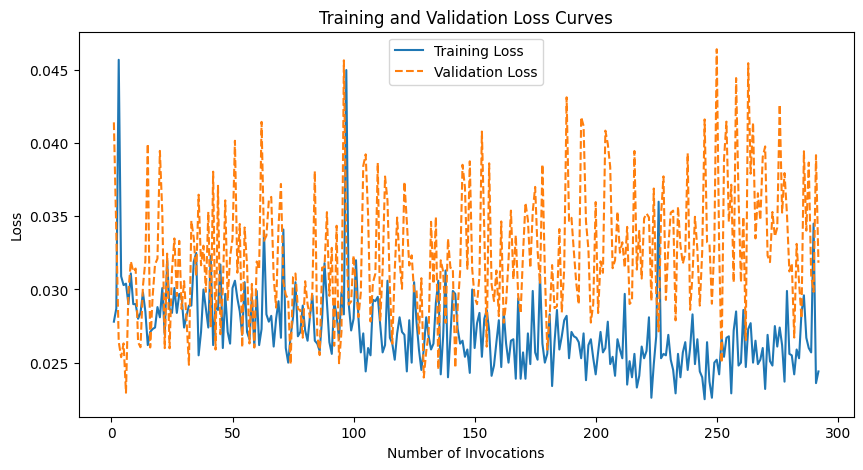

In [ ]:
# This cell trains the model.
# Note that to follow the same process as was used to train the model used,


from torch.utils.data import random_split
from transformers import Trainer, TrainingArguments

# Training arguments
training_args = TrainingArguments(
    output_dir=segformer_inference_dir_1,
    num_train_epochs= 200,
    per_device_train_batch_size=1,#20
    per_device_eval_batch_size=5,
    learning_rate=1e-4
    warmup_steps=1,
    weight_decay=0.01, # weight decay helps prevent high weights, reducing model variance
    logging_dir="./logs",
    evaluation_strategy="steps",
    logging_steps=150,
    eval_steps=150,
)


# Instantiate the custom callback
plotting_callback = PlottingCallback()

# Instantiate your custom callback, passing the model explicitly
custom_save_callback = CustomSaveCallback(model=model, save_dir=dir+'/models/segformer003', save_steps=500)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=custom_collate_fn,
    compute_metrics=compute_metrics,
    callbacks=[plotting_callback, custom_save_callback],  # Add your callback here
)

# Train the model
trainer.train()
# After training, plot the loss curves
plotting_callback.plot_loss_curves()


Now run inference with SegFormer model

In [53]:
# Saves model weights
os.makedirs(dir+'/models/segformer003', exist_ok=True)
torch.save(model.state_dict(), dir+'/models/segformer003'+'/model_weights.pth')

In [ ]:
# done modifying model for inference

In [111]:
# Defines a function to load and preprocess an image, returning it in a form
# such that it is ready to be inserted into the model.

from torchvision.transforms import Compose, ToTensor, Normalize
from PIL import Image
import numpy as np

def load_and_preprocess_image(image_path):
    # Load image
    image = Image.open(image_path).convert("RGB")

    if SCALESWITCH:
        # 4x the input image dimensions

        # Get original dimensions
        original_width, original_height = image.size
        # Calculate new dimensions
        new_width = original_width * 4
        new_height = original_height * 4
        # Resize image to new dimensions with nearest neighbor interpolation
        dimage = image.resize((new_width, new_height), Image.NEAREST)

    # Define transformations
    transform = Compose([
        ToTensor(),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    # Apply transformations
    image = transform(image)
    # Add batch dimension (C, H, W) -> (1, C, H, W)
    image = image.unsqueeze(0)
    return image

# image_path = dir+'/nnUNet_folders/nnUNet_raw/Dataset001_Base/imagesTs-External/External_img_053_0000.png'  # Update this to the path of your image
image_path = dir+'/nnUNet_folders/nnUNet_raw/Dataset001_Base/imagesTs-Internal/Internal_img_022_0000.png'  # Update this to the path of your image
# image_path = '/content/drive/MyDrive/Internal-ML-Quiz-WangLab/CWD/nnUNet_folders/nnUNet_raw/Dataset001_Base/imagesTr/img_005_0000.png'  # Update this to the path of your image
image = load_and_preprocess_image(image_path)

In [112]:
# Prepares the model for inference.

model.eval()  # Set the model to evaluation mode

with torch.no_grad():  # Disable gradient calculation for inference
    image = image.to(device)
    predictions = model(image)
    predictions = predictions.logits  # Get the logits from the model's output

In [113]:
# Makes the prediction on the image

# Apply softmax to convert logits to probabilities
probabilities = torch.nn.functional.softmax(predictions, dim=1)

# Get the predicted class for each pixel
predicted_mask = torch.argmax(probabilities, dim=1)
predicted_mask = predicted_mask.squeeze().cpu().numpy()  # Remove batch dimension and convert to numpy array


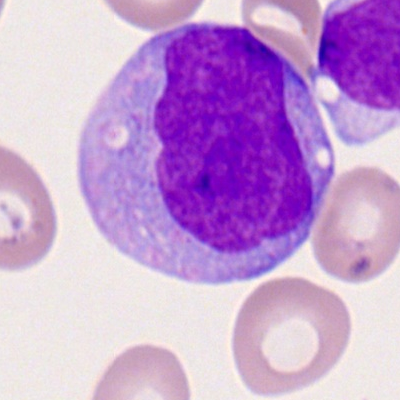

In [114]:
display_image(image_path) # Displays the original image

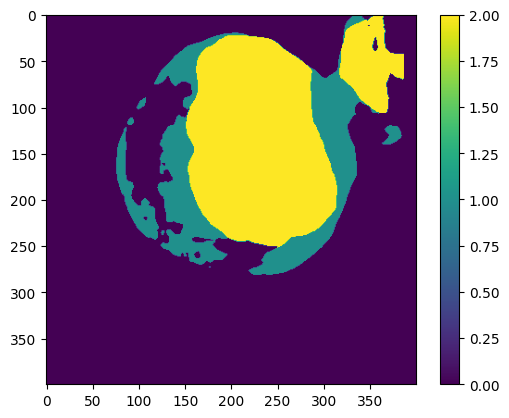

In [115]:
# Displays the predicted mask

import matplotlib.pyplot as plt

plt.imshow(predicted_mask, cmap='viridis')
plt.colorbar()
plt.show()

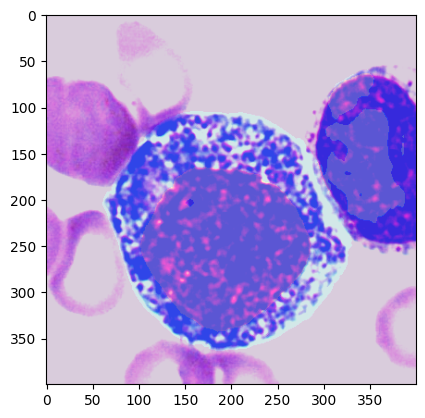

In [81]:
import matplotlib.pyplot as plt

# Overlay the mask on the image
plt.imshow(image.to('cpu')[0].permute(1, 2, 0), alpha=0.8)
plt.imshow(predicted_mask, alpha=0.2)

# Show the plot
plt.show()

In [ ]:
predicted_mask.shape

(363, 360)

In [98]:
# Done running ineference

Run full folder inference

In [99]:
# Create the directory if it doesn't exist
os.makedirs(dir+'/inferences/segformer', exist_ok=True)
os.makedirs(dir+'/inferences/segformer/003', exist_ok=True)
os.makedirs(dir+'/inferences/segformer/003/seg-Internal-Trans', exist_ok=True)
os.makedirs(dir+'/inferences/segformer/003/seg-External-Trans', exist_ok=True)

In [102]:
import cv2

In [103]:
# Runs inference on internal


for i in range(0, 77):
    if i<10:
        img_num = '00'+str(i)
    else:
        img_num = '0'+str(i)
    # print("Inference Label:")
    # display_image(nnUNet_inference_dir_3 + '/Internal_img_'+img_num+'.png', LABEL = True) # Inference Label
    # print()
    # print("External Test Image:")

    image_path = dir+"/nnUNet_folders/nnUNet_raw/Dataset001_Base/imagesTs-Internal"+"/Internal_img_"+img_num+"_0000.png"
    image = load_and_preprocess_image(image_path)

    # Makes the prediction on the image
    with torch.no_grad():  # Disable gradient calculation for inference
        image = image.to(device)
        predictions = model(image)
        predictions = predictions.logits  # Get the logits from the model's output

    # Apply softmax to convert logits to probabilities
    probabilities = torch.nn.functional.softmax(predictions, dim=1)

    # Get the predicted class for each pixel
    predicted_mask = torch.argmax(probabilities, dim=1)
    predicted_mask = predicted_mask.squeeze().cpu().numpy()  # Remove batch dimension and convert to numpy array

    # Ensure the data type is appropriate for saving; it should be an 8-bit unsigned integer.
    predicted_mask_uint8 = predicted_mask.astype('uint8')
    # Save the image directly without any scaling or color mapping
    cv2.imwrite(dir+ '/inferences/segformer/003/seg-Internal-Trans'+'/Internal_img_'+img_num+'_label.png', predicted_mask_uint8)

    # # Assuming predicted_mask is your numpy array
    # plt.imsave(dir+'/inferences/segformer/003/seg-Internal-Trans'+'/Internal_img_'+img_num+'_label.png', predicted_mask)

In [104]:
# Runs inference on external

for i in range(0, 60):
    if i<10:
        img_num = '00'+str(i)
    else:
        img_num = '0'+str(i)
    # print("Inference Label:")
    # display_image(nnUNet_inference_dir_3 + '/External_img_'+img_num+'.png', LABEL = True) # Inference Label
    # print()
    # print("External Test Image:")

    image_path = dir+"/nnUNet_folders/nnUNet_raw/Dataset001_Base/imagesTs-External"+"/External_img_"+img_num+"_0000.png"
    image = load_and_preprocess_image(image_path)

    # Makes the prediction on the image
    with torch.no_grad():  # Disable gradient calculation for inference
        image = image.to(device)
        predictions = model(image)
        predictions = predictions.logits  # Get the logits from the model's output

    # Apply softmax to convert logits to probabilities
    probabilities = torch.nn.functional.softmax(predictions, dim=1)

    # Get the predicted class for each pixel
    predicted_mask = torch.argmax(probabilities, dim=1)
    predicted_mask = predicted_mask.squeeze().cpu().numpy()  # Remove batch dimension and convert to numpy array

    # Ensure the data type is appropriate for saving; it should be an 8-bit unsigned integer.
    predicted_mask_uint8 = predicted_mask.astype('uint8')
    # Save the image directly without any scaling or color mapping
    cv2.imwrite(dir+ '/inferences/segformer/003/seg-External-Trans'+'/External_img_'+img_num+'_label.png', predicted_mask_uint8)

    # # Assuming predicted_mask is your numpy array
    # plt.imsave(dir+'/inferences/segformer/003/seg-External-Trans'+'/External_img_'+img_num+'_label.png', predicted_mask, cmap='gray')

In [ ]:
# just used to visualize masks

import os
from PIL import Image
import glob

# input_folder = dir+ '/inferences/segformer/003/seg-External-Trans'
input_folder = '/content/drive/MyDrive/Internal-ML-Quiz-WangLab/CWD/inferences/nnUNet_inferences/nnUNet_inference_1/imagesTs-Internal'
output_folder = '/content/drive/MyDrive/pnggreys'

# Create the output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Find all PNG files in the input directory
png_files = glob.glob(os.path.join(input_folder, '*.png'))

for file_path in png_files:
    # Open the image
    img = Image.open(file_path)
    # Convert the image to a numpy array for manipulation
    img_array = np.array(img)

    # Scale the image to account for the max pixel value of 2
    # Normalize between 0 and 1 then scale to 0-255
    img_array = (img_array / 2.0) * 255.0
    img_array = img_array.astype(np.uint8)

    # Convert the numpy array back to an image
    img_scaled = Image.fromarray(img_array)

    # Save the scaled image to the output folder
    base_name = os.path.basename(file_path)
    output_path = os.path.join(output_folder, base_name)
    img_scaled.save(output_path)

print("All images have been processed and saved.")
